# Predicting Cryptocurrency price using LSTM

## Get data
We will use the `get_data.py` script that is prepared to get data from a given crypto since given date

In [1]:
!python3 get_data.py --crypto-name BTC --start-date 2014-1-1 --save-path btc-usd_data.parquet

BTC
[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2014-09-17  465.864014  468.174011  ...  457.334015  21056800
2014-09-18  456.859985  456.859985  ...  424.440002  34483200
2014-09-19  424.102997  427.834991  ...  394.795990  37919700
2014-09-20  394.673004  423.295990  ...  408.903992  36863600
2014-09-21  408.084991  412.425995  ...  398.821014  26580100

[5 rows x 6 columns]


## Load data

In [2]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_parquet("data/btc-usd_data.parquet")
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-05-14,62900.773438,63092.125000,61123.765625,61552.789062,61552.789062,28186271527
2024-05-15,61553.988281,66454.453125,61330.410156,66267.492188,66267.492188,39815167074
2024-05-16,66256.109375,66712.429688,64613.054688,65231.582031,65231.582031,31573077994


## Data exploration

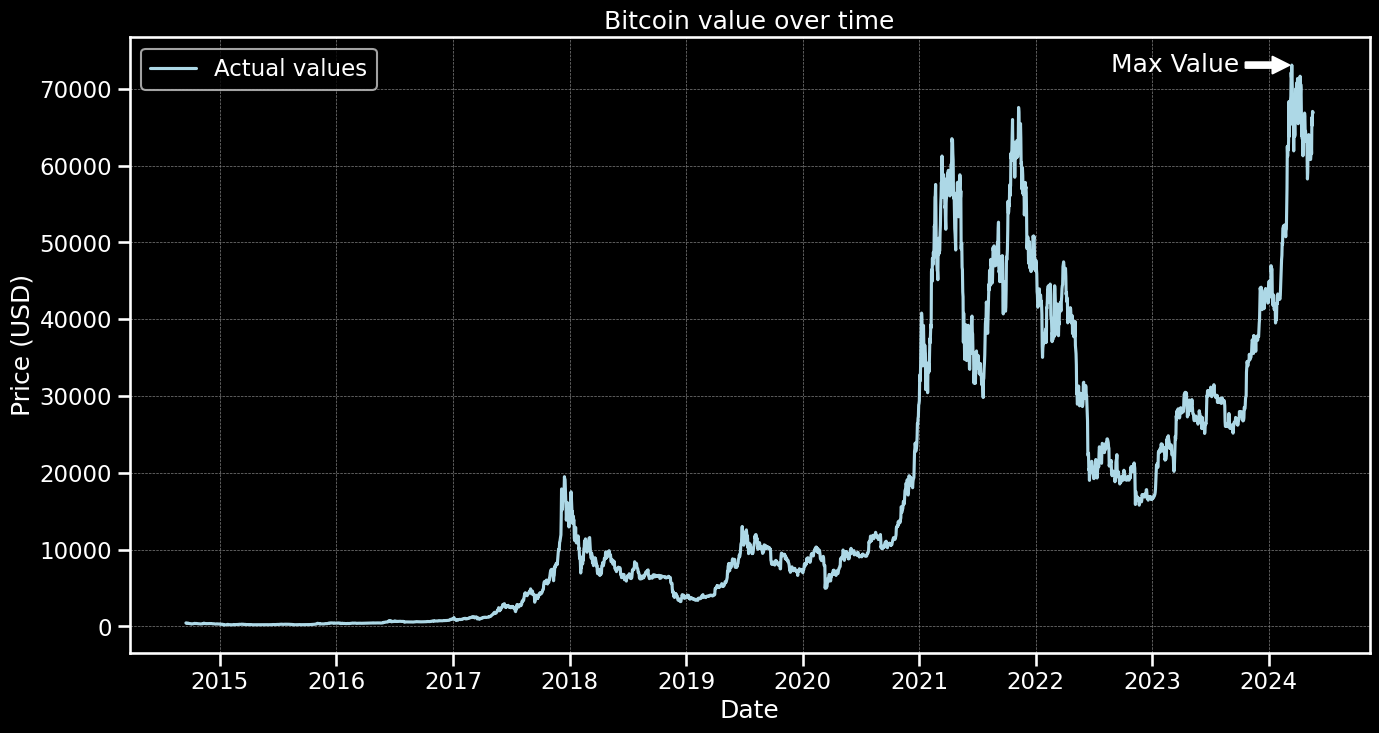

In [4]:
# Configure Seaborn style and color palette
sns.set_theme(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set_palette("bright")

plt.figure(figsize=(16, 8))
plt.plot(data.index.date, data["Close"], label="Actual values", color="lightblue")

# Add grid with appropriate color for dark background
plt.grid(True, which="both", color="gray", linestyle="--", linewidth=0.5)

# Suppose you want to highlight the maximum value
max_value = data["Close"].max()
max_date = data["Close"].idxmax()

# Annotate at the maximum value, with text to the left and vertically centered
plt.annotate("Max Value", 
             xy=(max_date, max_value), 
             xytext=(max_date - timedelta(days=365*1), max_value),
             arrowprops=dict(facecolor='white', shrink=0.05), 
             horizontalalignment="center",
             verticalalignment="center")

plt.title("Bitcoin value over time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()

# Save plot
plt.savefig("bitcoin_price_over_time.jpg", dpi=200)
# Show plot
plt.show()


## Split data

We are going to use data between 2014 and 2022 for training and between 2022 and 2023 for testing

In [5]:
train = data[:"2023-06"]["Close"]
test = data["2023-07":]["Close"]

In [8]:
train.shape, test.shape

((3209,), (323,))

In [9]:
train.tail()

Date
2023-06-26    30271.130859
2023-06-27    30688.164062
2023-06-28    30086.246094
2023-06-29    30445.351562
2023-06-30    30477.251953
Name: Close, dtype: float64

In [10]:
test.head()

Date
2023-07-01    30590.078125
2023-07-02    30620.769531
2023-07-03    31156.439453
2023-07-04    30777.582031
2023-07-05    30514.166016
Name: Close, dtype: float64

In [11]:
print(f"Proportion used for test: {len(test)/len(train):.4f}")

Proportion used for test: 0.1007


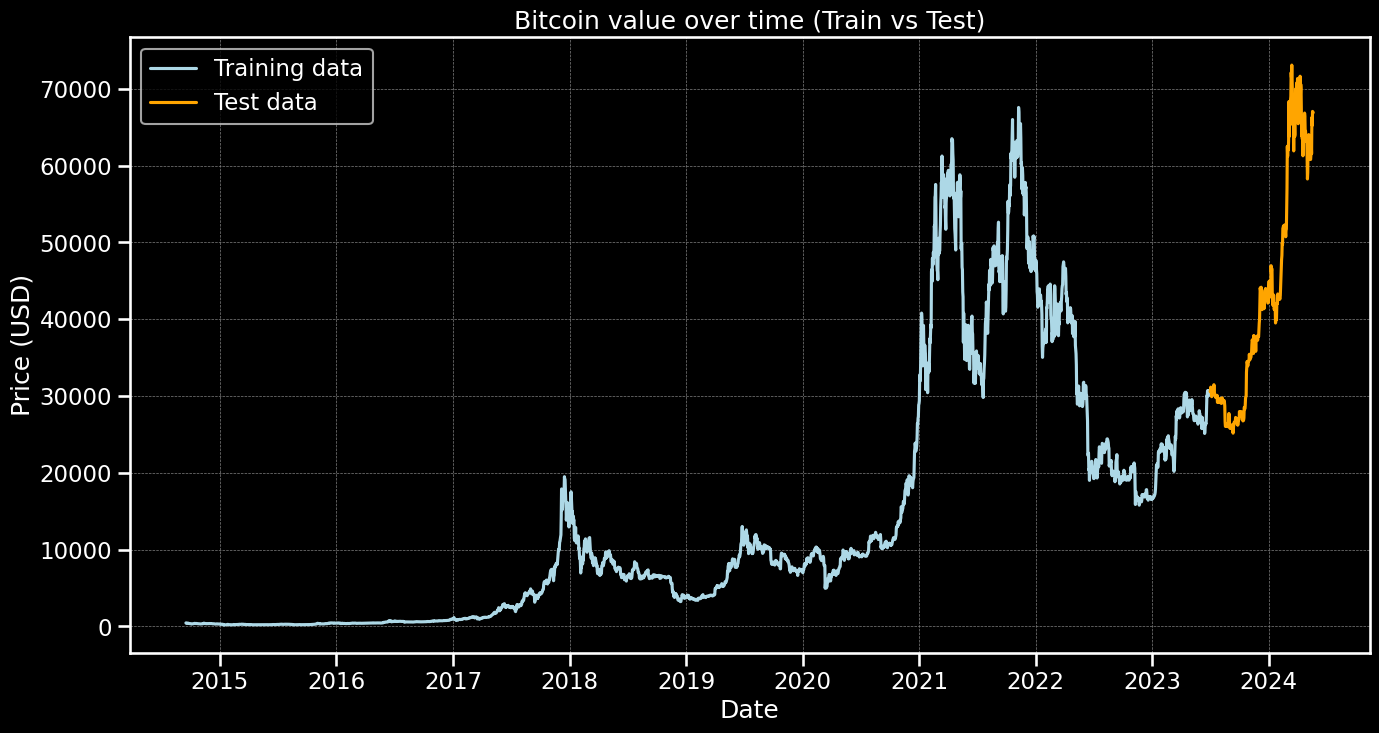

In [12]:
# Configure Seaborn style and color palette
sns.set_theme(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set_palette("bright")

plt.figure(figsize=(16, 8))

# Plot the training data
plt.plot(train.index, train.values, label="Training data", color="lightblue")

# Plot the test data
plt.plot(test.index, test.values, label="Test data", color="orange")

# Add grid with appropriate color for dark background
plt.grid(True, which="both", color="gray", linestyle="--", linewidth=0.5)

plt.title("Bitcoin value over time (Train vs Test)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()

# Save plot
plt.savefig("bitcoin_price_train_vs_test.jpg", dpi=200)
# Show plot
plt.show()

## Preprocess data

### Scale to 0-1 range

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

In [17]:
train_scaled

array([[-0.81931837],
       [-0.82137317],
       [-0.82322495],
       ...,
       [ 1.0315192 ],
       [ 1.05395154],
       [ 1.05594427]])

In [18]:
train_scaled.min(), train_scaled.max()

(-0.8367611722894347, 3.372829237523238)

### Generate batches of N days

In [19]:
prediction_days = 60

X_train, y_train = [], []

for x in range(prediction_days, len(train_scaled)):
    X_train.append(train_scaled[x-prediction_days:x, 0])
    y_train.append(train_scaled[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [20]:
X_train.shape

(3149, 60, 1)

## Create the model

### Model 1: One layer with 32 neurons

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(LSTM(units=32, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model1.add(Dropout(0.10))
model1.add(Dense(units=1))
model1.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")

### Model 2: Two layers with 32 neurons

In [22]:
model2 = Sequential()
model2.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(0.2))
model2.add(LSTM(units=32, return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))
model2.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")

## Train models

In [23]:
epochs = 50
batch_size = 64

### Model 1

In [24]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model1_history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

2024-05-19 00:58:37.236033: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-05-19 00:58:39.317280: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4e21995730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-19 00:58:39.317519: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-19 00:58:39.433432: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716080319.875628   93537 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [26]:
model1.save("model1.keras")

### Model 2

In [27]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 32)            4352      
                                                                 
 dropout_1 (Dropout)         (None, 60, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model2_history = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

In [29]:
model2.save("model2.keras")

## Training curves

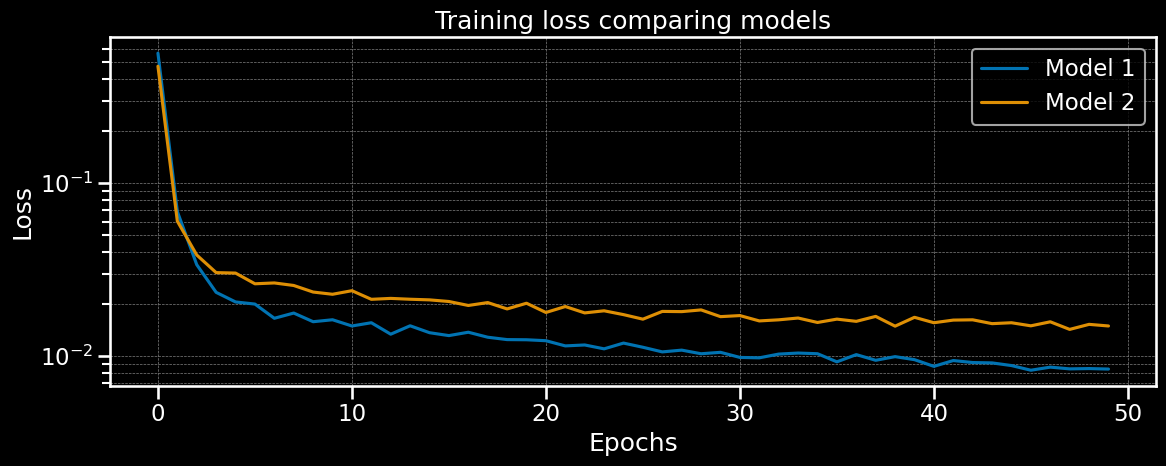

In [30]:
loss1 = model1_history.history["loss"]
loss2 = model2_history.history["loss"]

# Set the background to dark gray and the grid to white
sns.set_theme(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set_palette("bright")
sns.set_palette("pastel")
sns.set_palette("deep")
sns.set_palette("colorblind")

# Create the loss plot using Seaborn
plt.figure(figsize=(12, 5))
sns.lineplot(data=loss1, dashes=False, label="Model 1")
sns.lineplot(data=loss2, dashes=False, label="Model 2")

# Customize the plot
# plt.legend(labels=["Model 1 loss", "Model 2 loss", "Model 3 loss"])
plt.title("Training loss comparing models")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")

# Add grid with appropriate color for dark background
plt.grid(True, which="both", color="gray", linestyle="--", linewidth=0.5)

plt.tight_layout()

# sns.despine()
# Save the plot
plt.savefig("LSTM_training_model_compare.jpg", dpi=200)
# Show the plot
plt.show()

In [49]:
model1_loss_train = model1.evaluate(X_train, y_train)
model2_loss_train = model2.evaluate(X_train, y_train)

print(f"Model 1 loss (train): {model1_loss_train:.4f}")
print(f"Model 2 loss (train): {model2_loss_train:.4f}")

99/99 [==============================] - 2s 16ms/step - loss: 0.0050
Model 1 loss (train): 0.0045
Model 2 loss (train): 0.0050


## Test model

### Generate test batches

In [31]:
test_scaled = scaler.transform(test.values.reshape(-1, 1))

prediction_days = 60

X_test, y_test = [], []

for x in range(prediction_days, len(test_scaled)):
    X_test.append(test_scaled[x-prediction_days:x, 0])
    y_test.append(test_scaled[x, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [34]:
model1_loss = model1.evaluate(X_test, y_test)
model2_loss = model2.evaluate(X_test, y_test)

print(f"Model 1 loss: {model1_loss:.4f}")
print(f"Model 2 loss: {model2_loss:.4f}")

9/9 [==============================] - 2s 19ms/step - loss: 0.0147
Model 1 loss: 0.0152
Model 2 loss: 0.0147


In [35]:
# Predict using each model
prediction_model1 = model1.predict(X_test)
prediction_model2 = model2.predict(X_test)

# Inverse scale to predictions
prediction_model1 = scaler.inverse_transform(prediction_model1)
prediction_model2 = scaler.inverse_transform(prediction_model2)

# Reshape true values
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

9/9 [==============================] - 0s 19ms/step


In [36]:
prediction_model1.shape, y_true.shape

((263, 1), (263, 1))

In [37]:
dates = test.iloc[60:]

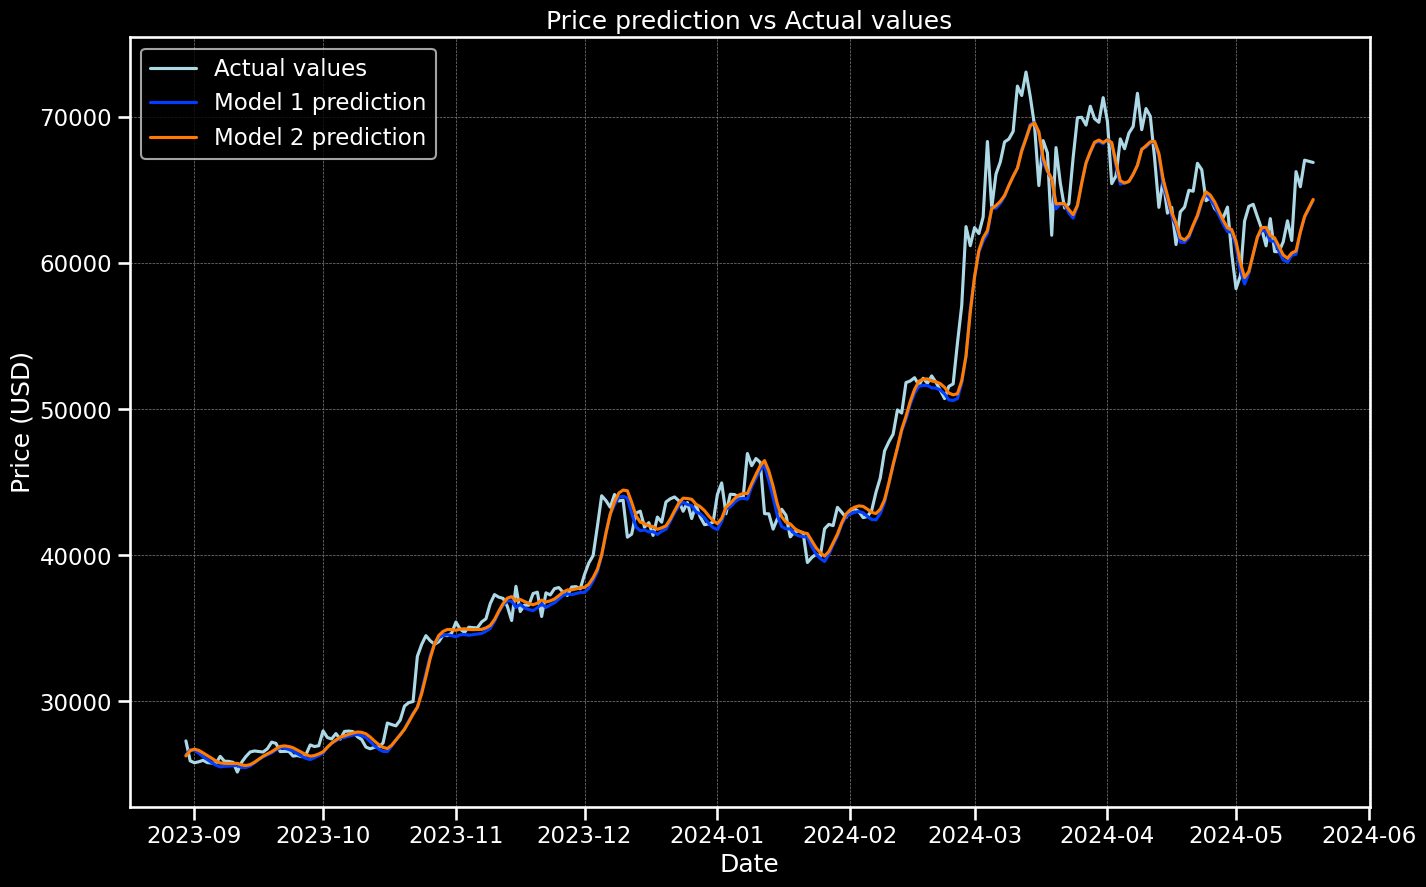

In [40]:
sns.set_theme(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set_palette("bright")

plt.figure(figsize=(16, 10))
plt.plot(dates.index.date, y_true, label="Actual values", c="lightblue")
plt.plot(dates.index.date, prediction_model1, label="Model 1 prediction")
plt.plot(dates.index.date, prediction_model2, label="Model 2 prediction")

# Add grid with appropriate color for dark background
plt.grid(True, which="both", color="gray", linestyle="--", linewidth=0.5)

plt.title("Price prediction vs Actual values")
plt.xlabel("Date")
plt.ylabel("Price (USD)")

plt.legend()
# Save plot
plt.savefig("LSTM_predict_model_compare.jpg", dpi=200)
# Show plot
plt.show()

## Model error

In [41]:
error_model1 = (prediction_model1 - y_true).flatten()
error_model2 = (prediction_model2 - y_true).flatten()

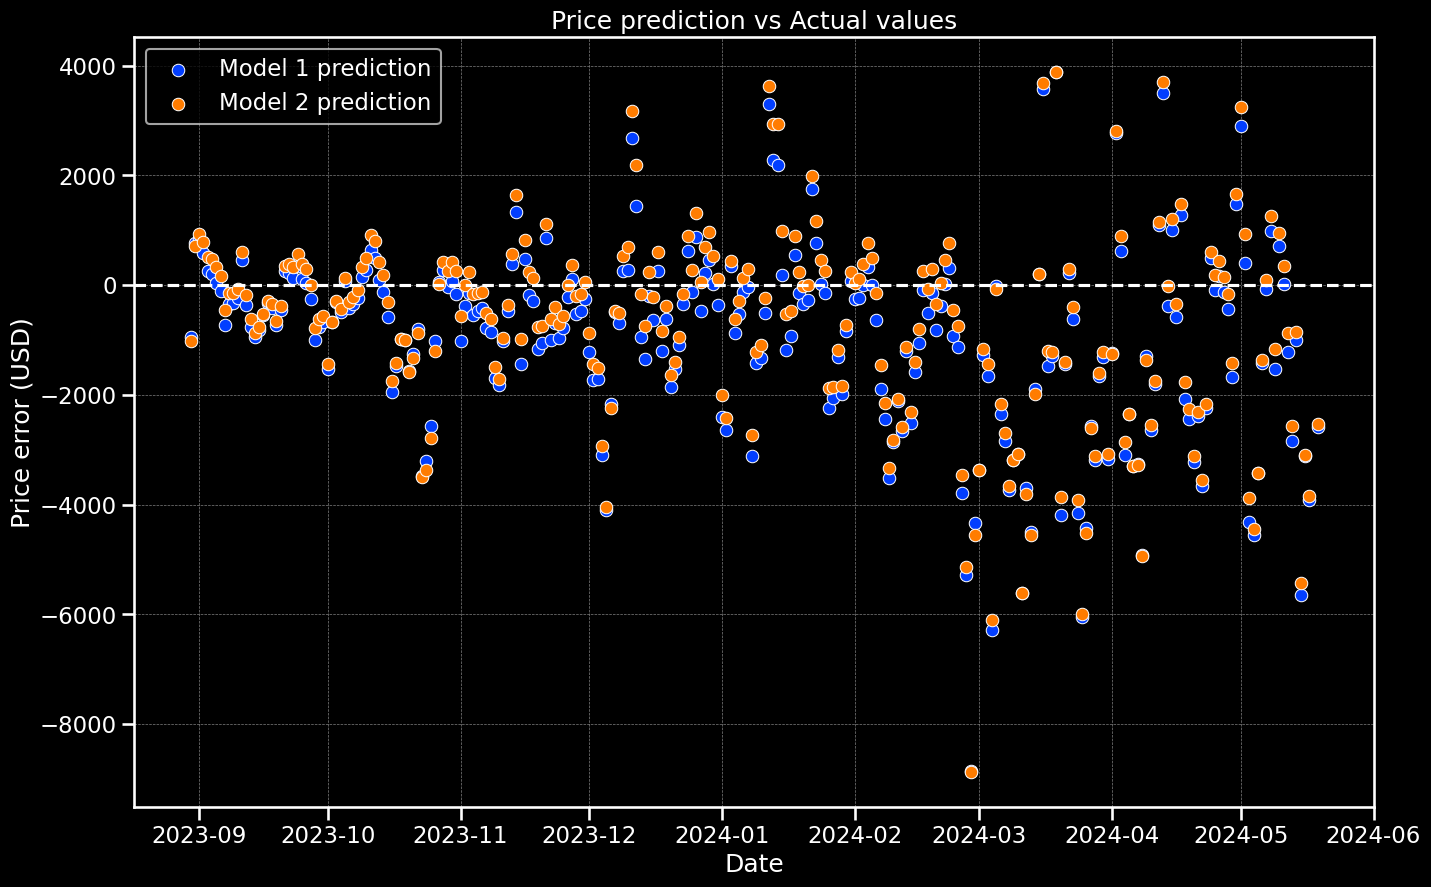

In [48]:
sns.set_theme(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set_palette("bright")
# sns.set_palette("deep")
# sns.set_palette("colorblind")
# sns.set_palette("pastel")

plt.figure(figsize=(16, 10))
plt.title("Price prediction vs Actual values")

plt.axhline(0, linestyle="dashed", color="white")
sns.scatterplot(x=dates.index.date, y=error_model1, label="Model 1 prediction")
sns.scatterplot(x=dates.index.date, y=error_model2, label="Model 2 prediction")
# plt.axhline(, color="yellow", linestyle="--", linewidth=2)

# Add grid with appropriate color for dark background
plt.grid(True, which="both", color="gray", linestyle="--", linewidth=0.5)

plt.xlabel("Date")
plt.ylabel("Price error (USD)")
plt.legend()
# Save plot
plt.savefig("LSTM_predict_model_error_compare.jpg", dpi=200)

plt.show()

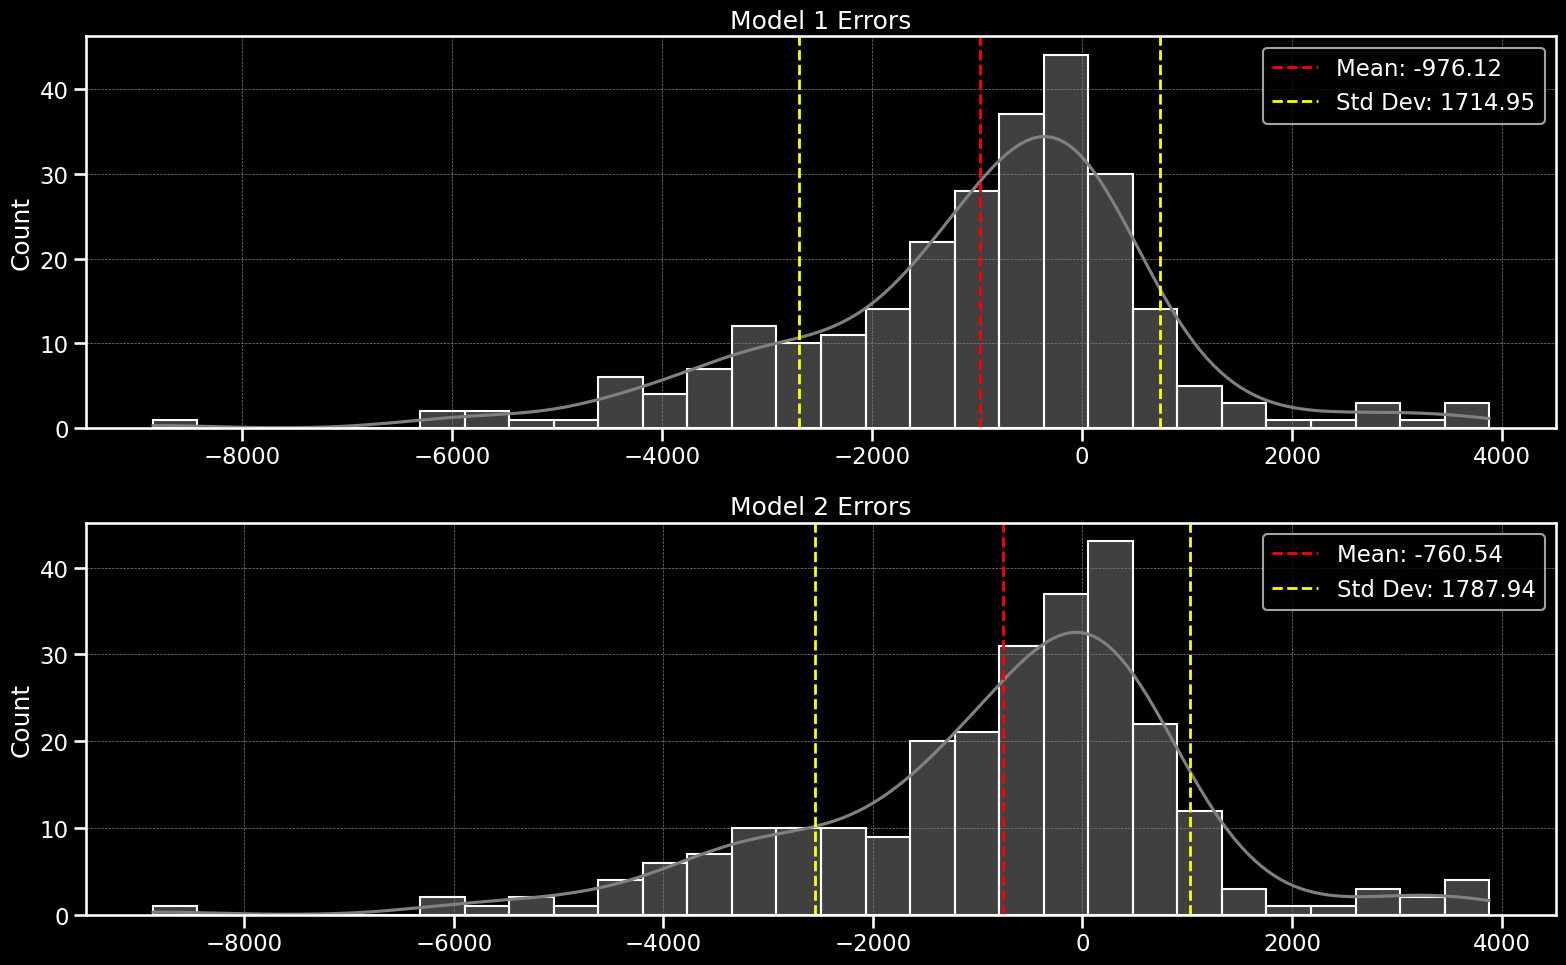

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# List of errors and titles for the subplots
errors = [error_model1, error_model2]
titles = ["Model 1 Errors", "Model 2 Errors"]

for i, ax in enumerate(axes):
    # Plot the error distribution
    sns.histplot(errors[i], kde=True, ax=ax, color="gray", bins=30)
    
    # Calculate the mean and standard deviation
    mean = np.mean(errors[i])
    std = np.std(errors[i])
    
    # Add lines for the mean and standard deviation
    ax.axvline(mean, color="red", linestyle="--", linewidth=2, label=f"Mean: {mean:.2f}")
    ax.axvline(mean + std, color="yellow", linestyle="--", linewidth=2, label=f"Std Dev: {std:.2f}")
    ax.axvline(mean - std, color="yellow", linestyle="--", linewidth=2)
    # Add grid with appropriate color for dark background
    ax.grid(True, which="both", color="gray", linestyle="--", linewidth=0.5)
    
    # Title and legend
    ax.set_title(titles[i])
    ax.legend()

# Adjust the layout to prevent label overlap
plt.tight_layout()

# Save plot
plt.savefig("errors_distribution.jpg", dpi=200)

# Show plot
plt.show()

# Final thoughts

I've trained two LSTM models to predict the Bitcoin value: one with one layer and another with two layers. During training, the single-layer model (model 1) showed slightly lower loss than the two-layer model (model 2).  

## Results
**Training Results:**
- **Model 1:** Training loss = 0.0045
- **Model 2:** Training loss = 0.0050

**Evaluation Results:**
- **Model 1:** Loss = 0.0152
- **Model 2:** Loss = 0.0147

**Evaluation Results:**
- **Model 1:** 
    - Mean error: -976 USD
    - Standard deviation of error: 1714 USD
- **Model 2:** 
    - Mean error: -760 USD
    - Standard deviation of error: 1787 USD

## Conclusion
During training, model 1 achieved slightly better loss metrics for a very small difference. However, when evaluating both models on test data, model 2 showed superior performance. This suggests that model 2, despite having higher loss on the training data, has better generalization capability for unseen data.

Analyzing the errors of both models, we observe that model 2 has a mean error closer to 0, with a difference of over 200 USD. Although model 2 has a slightly higher standard deviation of error, I would choose to use model 2 due to its better generalization capability and a mean error closer to 0 on test data.

In summary, **model 2 demonstrated a greater ability to generalize** and predict accurate values for unseen data, which is crucial in real-world applications where working with new and unknown data is common.